In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# PB1:

In [2]:
# Define variables used throughout ex1 and ex2
L = np.array([[0,2/5,1/5,0,0],[0,0,3/4,1/4,0],[1/2,0,0,1/3,0],[0,0,1/3,0,2/3],[0,1/2,0,1/3,0]])
omega = np.sum(L,axis=1)
omega_s = np.max(omega)
Pbar = L/omega_s
for i in range(len(Pbar)):
    Pbar[i,i] = 1-np.sum(Pbar[i])

states = ['o','a','b','c','d']

In [3]:
# Random walk simulation, if objective is None it simply runs until the time reaches timelim
def walk(states,x0,rate,transition,timelim=60,objective=None):
    t=0
    path = [x0]
    x = x0
    if objective!=None:
        while x==objective:# If the objective is the start point you need to leave it first
            prev = x
            u = np.random.random()
            t_next = -np.log(u)/rate# Compute time till next tick of the clock
            t+=t_next
            x = np.random.choice(states,p=transition[states.index(prev)])# Choose new state
            if x!=prev:
                path.append(x)
        while x!=objective:# Loop until you reach the objective
            prev = x
            u = np.random.random()
            t_next = -np.log(u)/rate
            t += t_next
            x = np.random.choice(states,p=transition[states.index(prev)])
            if x!=prev:
                path.append(x)
        
        return t,path


    else:# Loop if you don't have an objective and just want to simulate a walk for a certain duration, not used in the exercises but interesting to have
        u = np.random.random()
        t_next = -np.log(u)/rate
        t+=t_next
        while t<timelim:
            prev = x
            x = np.random.choice(states,p=transition[states.index(prev)])
            if x!=prev:
                path.append(x)
            u = np.random.random()
            t_next = -np.log(u)/rate
            t+=t_next
        return path



### a)

In [4]:
times = []
for _ in range(10000):
    times.append(walk(states,'a',omega_s,Pbar,objective='a')[0])
print('Average time to return to node a starting from a:',np.mean(times))

Average time to return to node a starting from a: 6.031760186586339


In [5]:
# Computes the invariant distribution of a stohastic matrix
def calcpi(P):
    a,b=np.linalg.eig(P.T)# Get eigenvalues/vectors of P transpose
    ind = np.argmin(np.abs(a-1))# Get the index of 1 in the eigenvalue list
    pi = b[:,ind].real# Get the eigenvector of P transpose associated with 1
    pi /= np.sum(pi)# Normalize the eigenvector
    return pi

pibar = calcpi(Pbar)

### b)

In [6]:
print('theoretical return time:',1/(pibar[1]*omega[1]))# Apply the slides' formula

theoretical return time: 6.058823529411766


### c)

In [7]:
times = []
for _ in range(10000):
    times.append(walk(states,'o',omega_s,Pbar,objective='d')[0])
print('Average time to reach node d starting from o:',np.mean(times))

Average time to reach node d starting from o: 10.839588492273393


### d)

In [8]:
P = L/omega[:,None]
objective = 'd'
n = len(states)
id = states.index(objective)# Index of the node which you want to compute the travel times to 
Phat = np.delete(np.delete(P,id,axis=0),id,axis=1)# P without the line and the column whose index corresponds to the objective node
sol = np.linalg.solve(np.identity(n-1)-Phat,1/np.delete(omega,id))# The travel times are the solution to the system s = Phat*s+1/omega
traveltimes = np.zeros(n)# Construct the list of all travel times to the objective node
for i in range(id):
    traveltimes[i] = sol[i]
for i in range(id+1,n):
    traveltimes[i] = sol[i-1]

print('Expected travel times from all nodes to objective node:',traveltimes)
print('Expected travel time from o to d:',traveltimes[0])

Expected travel times from all nodes to objective node: [10.76666667  9.          9.3         4.1         0.        ]
Expected travel time from o to d: 10.766666666666666


### e)

In [9]:
# Run French de Groot dynamics, stops if there is very low change between two consecutive steps, end in an error else
def FdG(P,x0,iter,eps=1e-8):
    x = x0
    for _ in range(iter):
        new = P@x
        if np.linalg.norm(x-new)<eps:
            return new
        else:
            x = new
    raise TimeoutError("Algorithm didn't converge")

In [10]:
j = np.random.random(5)
print('Initial states:',j)
pi = calcpi(P)
print('Theoretical consensus value:',pi@j)
print(FdG(P,j,1000))

Initial states: [0.27937356 0.8132976  0.02018423 0.6170533  0.97933345]
Theoretical consensus value: 0.48809189104678086
[0.48809189 0.48809189 0.48809189 0.48809189 0.48809189]


The French de Groot model always converges because graph is strongly connected and aperiodic and the limit is a consensus. Consensus value is dependent on the initial value though.

### f)

In [11]:
consensus = []
for _ in range(10000):
    x0 = [np.random.normal(0,1),np.random.normal(0,np.sqrt(2)),np.random.normal(0,np.sqrt(2)),np.random.normal(0,np.sqrt(2)),np.random.normal(0,1)]
    consensus.append(np.mean(FdG(P,x0,1000)))
print('Simulated variance of the consensus value:',np.var(consensus))
print('Theoretical variance of the consensus value:',(pi**2)@[1,2,2,2,1])

Simulated variance of the consensus value: 0.3793893086459603
Theoretical variance of the consensus value: 0.372165511447175


### g)

In [12]:
L2 = np.array([[0,2/5,1/5,0,0],[0,0,3/4,0,0],[1/2,0,0,0,0],[0,0,1/3,0,2/3],[0,0,0,0,0]])# Transition matrix of the new graph
omega = np.sum(L2,axis=1)
omega[-1]=1
P2 = L2/omega[:,None]# Normalzied transition matrix

In [13]:
x0 =np.random.random(5)
print(FdG(P2,x0,1000))

[0.60854933 0.60854933 0.60854933 0.20284978 0.        ]


In [14]:
pi2 = calcpi(P2)
print(pi2)
print('Consensus value of {o,a,b}:',pi2@x0)

[ 0.375  0.25   0.375 -0.    -0.   ]
Consensus value of {o,a,b}: 0.6085493318433995


By removing all those links, the graph now has two sink components: {o,a,b} and {d}. The graph is still aperiodic so the nodes are able to locally come to a consensus. The two components do not communicate with each other so they each come to a different consensus then the remaining nodes (just c) adjust their opinion based on the two local consensus. Since c gives attention 1/3 to b and 2/3 to d, the final opinion of c will be a weighted average of the opinions of b and d but d's opinion is always 0 so the final opinion of c is the opinion of b divided by 3. B's opinion is in fact the weighted average of the initial opinions of nodes o, a and b by the invariant distribution of the graph whose support is on {o,a,b}.

### h)

In [15]:
L3 = np.array([[0,2/5,1/5,0,0],[0,0,3/4,1/4,0],[0,0,0,1/3,0],[0,0,1/3,0,2/3],[0,0,0,1/3,0]])# Transition matrix of the new graph
omega = np.sum(L3,axis=1)
P3 = L3/omega[:,None]

In [16]:
x0 = np.random.random(5)
print(FdG(P3,x0,1000))

TimeoutError: Algorithm didn't converge

In [18]:
print(x0)
for _ in range(10):
    x0 = P3@x0
    print(x0)

[0.22210737 0.16578306 0.42876585 0.15907678 0.24832095]
[0.25344399 0.36134358 0.15907678 0.30846925 0.15907678]
[0.29392132 0.1964249  0.30846925 0.15907678 0.30846925]
[0.23377302 0.27112113 0.15907678 0.30846925 0.15907678]
[0.23377302 0.1964249  0.30846925 0.15907678 0.30846925]
[0.23377302 0.27112113 0.15907678 0.30846925 0.15907678]
[0.23377302 0.1964249  0.30846925 0.15907678 0.30846925]
[0.23377302 0.27112113 0.15907678 0.30846925 0.15907678]
[0.23377302 0.1964249  0.30846925 0.15907678 0.30846925]
[0.23377302 0.27112113 0.15907678 0.30846925 0.15907678]
[0.23377302 0.1964249  0.30846925 0.15907678 0.30846925]


In [19]:
print(P3)
print()
print(P3@P3)
print()
print(P3@P3@P3)
print()
print(P3@P3@P3@P3)

[[0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.         0.         1.         0.        ]]

[[0.         0.         0.5        0.5        0.        ]
 [0.         0.         0.08333333 0.75       0.16666667]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.33333333 0.         0.66666667]]

[[0.         0.         0.16666667 0.5        0.33333333]
 [0.         0.         0.25       0.25       0.5       ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.         0.         1.         0.        ]]

[[0.         0.         0.16666667 0.5        0.33333333]
 [0.         0.         0.08333333 0.75       0.16666667]
 [0.    

In [20]:
print(FdG(P3,[1,8,13.4,13.4,13.4],1000))

[13.4 13.4 13.4 13.4 13.4]


In this question {b,c,d} is now a periodic component of the graph, on one step b and d have the same value and c has another, on the next step c takes b and d's value and b and d take c's value. French de Groot dynamics do not converge except if the initial values of b,c and d are equal in which case the model converges to a consensus whose value is the initial value of b,c and d. This is due to the fact that a updates its value based on b and c's value, if b=c then a gets the same value. Same for o it takes its value from a and b, once a=b, o is also equal to them and we reach consensus.

# PB2:

In [21]:
# Simulate a random walk of multiple particles from the particle perspective
def particle_pov(N,states,x0,rate,transition,timelim=60,objective='o'):
    t=0
    x = np.array([x0 for _ in range(N)])
    path = [[x0] for _ in range(N)]# Add all particles to node x0
    if objective == x0:
        quit = np.array([False for _ in range(N)])# Checks if each particle has left its initial position
        while t<timelim and not np.any((x==x0)&quit):# Loop ends once a particle has returned to the start or the time is over the limit
            ind = np.random.choice(N)# Choose a random particle to move
            prev = x[ind]# Check its position
            u = np.random.random()
            t_next = -np.log(u)/(N*rate)# Compute time to next tick of the clock
            t += t_next
            x[ind] = np.random.choice(states,p=transition[states.index(prev)])# Choose at random the next position of the particle
            if x[ind]!=prev:# If the particle changed position add the new one in the path it took
                path[ind].append(x[ind])
                if not quit[ind] and prev==x0:# If particle is leaving the start for the first time remember it has done so
                    quit[ind] = True
    else:
        while t<timelim and not np.any(x==objective):# This loop is used if we want to simulate hitting times, never used in the exercise
            ind = np.random.choice(N)
            prev = x[ind]
            u = np.random.random()
            t_next = -np.log(u)/(N*rate)
            t += t_next
            x[ind] = np.random.choice(states,p=transition[states.index(prev)])
            if x[ind]!=prev:
                path[ind].append(x[ind])

    return t,path

In [22]:
times=[]
for i in range(1000):
    times.append(particle_pov(100,states,'a',omega_s,Pbar,objective='a')[0])
print('Average time it takes a particle to get back to a:',np.mean(times))

Average time it takes a particle to get back to a: 0.6454641961066415


In [23]:
# Simulate a random walk of multiple particles from the node perspective
def node_pov(N,states,x0,rate,transition,timelim=60):
    n = len(states)
    particle_quantity = [[0] for _ in range(n)]
    particle_quantity[states.index(x0)][0] = N# Add all particles to node x0
    u = np.random.random()
    t = [0,-np.log(u)/(N*rate)]
    i = 1
    while t[i]<timelim:
        prob = np.array([particle_quantity[j][i-1] for j in range(n)])/N
        prev_node = np.random.choice(states,p=prob)# Choose a node at random proportionaly to the number of particles in it
        prev_ind = states.index(prev_node)
        new_node = np.random.choice(states,p=transition[prev_ind])# Choose the destination node
        new_ind = states.index(new_node)
        for ind in range(n):# The particle quantity of other nodes doesn't change
            if ind != prev_ind and ind != new_ind:
                particle_quantity[ind].append(particle_quantity[ind][i-1])
        if prev_ind == new_ind:# If the destination and the start are the same node, the quantities don't change as well
            particle_quantity[prev_ind].append(particle_quantity[prev_ind][i-1])
        else:# Otherwise the start node loses a particle and the destination gains one
            particle_quantity[prev_ind].append(particle_quantity[prev_ind][i-1]-1)
            particle_quantity[new_ind].append(particle_quantity[new_ind][i-1]+1)
        u = np.random.random()
        t_next = -np.log(u)/(N*rate)# Compute time to next clock tick
        t.append(t[i]+t_next)
        i += 1

    return t,particle_quantity 

In [24]:
avg = []
for _ in range(1000):
    _,q = node_pov(100,states,'a',omega_s,Pbar)
    avg.append([q[i][-1] for i in range(len(q))])
avg_repart = np.mean(avg,axis=0)
print(avg_repart)

[23.16 16.29 28.37 18.28 13.9 ]


In [25]:
print("Invariant distribution of Pbar:",pibar)

Invariant distribution of Pbar: [0.23058252 0.16504854 0.27669903 0.18203883 0.14563107]


In [26]:
print("Norm of the difference between invariant distribution and normalized occupancy of nodes:",np.linalg.norm(pibar-avg_repart/100))

Norm of the difference between invariant distribution and normalized occupancy of nodes: 0.00996069899929827


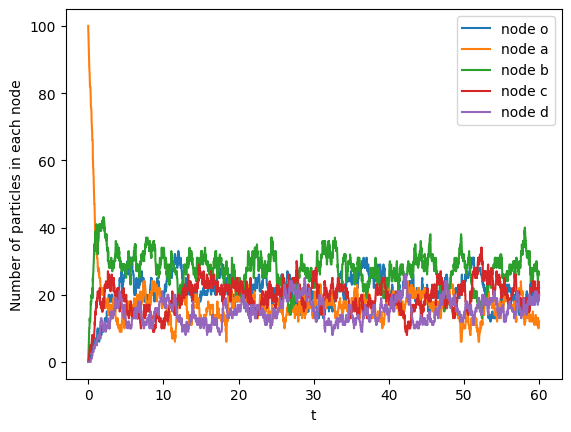

In [27]:
t,q = node_pov(100,states,'a',omega_s,Pbar)
for i in range(len(q)):
    plt.plot(t[:-1],q[i],label = 'node '+states[i])
plt.xlabel('t')
plt.ylabel('Number of particles in each node')
plt.legend()
plt.show()

# PB3:

In [28]:
# Define variables used in ex3
L = np.array([[0,3/4,3/4,0,0],[0,0,1/4,1/4,1/2],[0,0,0,1,0],[0,0,0,0,1],[0,0,0,0,0]])
omega = np.sum(L,axis=1)
omega[-1] = 2
omega_s = np.max(omega)
Pbar = L/omega_s
for i in range(len(Pbar)-1):
    Pbar[i,i] = 1-np.sum(Pbar[i])
P = L/omega[:,None]

states = ['o','a','b','c','d']

In [29]:
# Simulate the system where nodes have a proportional passing rate
def prop_rate(l,states,rate,transition,timelim=60):
    n = len(states)
    particle_quantity = [[0,0] for _ in range(n)]
    particle_quantity[0][1]=1
    N = 1

    #Compute every time at which a particle will enter the system
    t_input = [0]
    u = np.random.random()
    next = -np.log(u)/l
    i = 0
    while next< timelim:
        t_input.append(next)
        u = np.random.random()
        i += 1
        next = t_input[i]-np.log(u)/l


    t = [0,t_input[1]]
    i = 2
    input_i = 2
    u = np.random.random()
    t_pass = t[i-1]-np.log(u)/(N*rate)# Time at which node o will pass along its first particle
    for j in range(input_i,len(t_input)):
        if t_pass<t_input[j]:# Continue if o passes the particle before a new one enters
            t.append(t_pass)
            break
        else:# Else add all particles that should enter the network before o passes its first particle
            N += 1
            particle_quantity[0].append(j)
            for k in range(1,n):
                particle_quantity[k].append(0)
            t.append(t_input[j])
            i += 1
            input_i += 1
    
    
    while t_pass<timelim:
        prob = np.array([particle_quantity[j][i-1] for j in range(n)])/N
        prev_node = np.random.choice(states,p=prob)# Choose a node at random proportionaly to the number of particles in it 
        if prev_node == states[-1]:# If the chosen node is d, one particle exits the network 
            N -= 1
            particle_quantity[-1].append(particle_quantity[-1][i-1]-1)
            for ind in range(n-1):
                particle_quantity[ind].append(particle_quantity[ind][i-1])
        else:# In the other cases update the particle quantity of each node accordingly
            prev_ind = states.index(prev_node)
            new_node = np.random.choice(states,p=transition[prev_ind])
            new_ind = states.index(new_node)
            for ind in range(n):
                if ind != prev_ind and ind != new_ind:
                    particle_quantity[ind].append(particle_quantity[ind][i-1])    
            if prev_ind == new_ind:
                particle_quantity[prev_ind].append(particle_quantity[prev_ind][i-1])
            else:
                particle_quantity[prev_ind].append(particle_quantity[prev_ind][i-1]-1)
                particle_quantity[new_ind].append(particle_quantity[new_ind][i-1]+1)

        u = np.random.random()
        t_pass = t[i]-np.log(u)/(N*rate)# Compute the time to wait before the next node passes a particle
        for j in range(input_i,len(t_input)):
            if t_pass<t_input[j]:# Continue if no particle enters the network before that 
                break
            else:# Else add all the particles that enter the network before the next particle is passed
                N += 1
                particle_quantity[0].append(particle_quantity[0][i]+1)
                for k in range(1,n):
                    particle_quantity[k].append(particle_quantity[k][i])
                t.append(t_input[j])
                i += 1
                input_i += 1
                
        t.append(t_pass)       
        i += 1

    return t,particle_quantity 

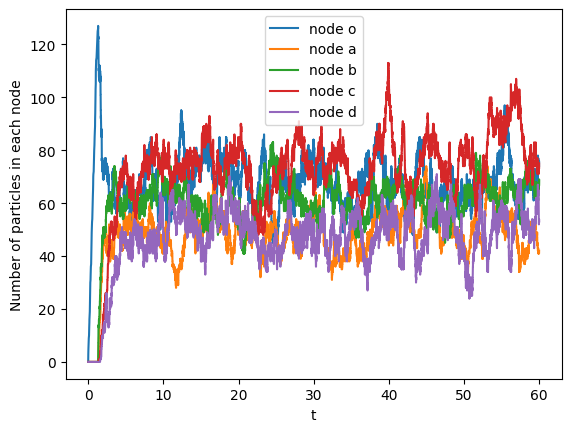

In [30]:
t,q=prop_rate(100,states,omega_s,Pbar)
for i in range(len(q)):
    plt.plot(t[:-1],q[i],label = 'node '+states[i])
plt.xlabel('t')
plt.ylabel('Number of particles in each node')
plt.legend()
plt.show()

In [31]:
# Simulate the system where nodes have a fixed passing rate
def fixed_rate(l,states,rates,transition,timelim=60):
    n = len(states)
    particle_quantity = [[0] for _ in range(n)]
    N = 0

    #Compute the ticking times of all clocks
    t = [(0,-1)]
    u = np.random.random()
    next = -np.log(u)/l
    j = 0
    while next<timelim:
        t.append((next,0))
        u = np.random.random()
        j += 1
        next = t[j][0]-np.log(u)/l
    for i in range(1,n+1):
        r = rates[i-1]
        u = np.random.random()
        next = -np.log(u)/r
        while next< timelim:
            t.append((next,i))
            u = np.random.random()
            j += 1
            next = t[j][0]-np.log(u)/r

    # Order all the ticking times and take note of which node is ticking
    t = sorted(t,key=lambda x:x[0])


    for i in range(1,len(t)):
        node = t[i][1]
        if node == 0:# node = 0 means a particle is added to the network
            N += 1
            particle_quantity[0].append(particle_quantity[0][i-1]+1)
            for ind in range(1,n):
                particle_quantity[ind].append(particle_quantity[ind][i-1])
        elif node == n:# node = n means node d's clock has ticked, one particle exits the network if possible
            if particle_quantity[-1][-1]>0:
                N -= 1
                particle_quantity[-1].append(particle_quantity[-1][i-1]-1)
            else:
                particle_quantity[-1].append(particle_quantity[-1][i-1])

            for ind in range(n-1):
                particle_quantity[ind].append(particle_quantity[ind][i-1])
        else:# In the other cases if there is at least a particle in the node pass it to a neighbour according to the transition probabilities provided
            node -= 1
            if particle_quantity[node][-1]>0:
                new_node = np.random.choice(states,p=transition[node])
                new_ind = states.index(new_node)
                for ind in range(n):
                    if ind != node and ind != new_ind:
                        particle_quantity[ind].append(particle_quantity[ind][i-1])    
                else:
                    particle_quantity[node].append(particle_quantity[node][i-1]-1)
                    particle_quantity[new_ind].append(particle_quantity[new_ind][i-1]+1)
            else:
                for ind in range(n):
                    particle_quantity[ind].append(particle_quantity[ind][i-1])

            
    return t,particle_quantity

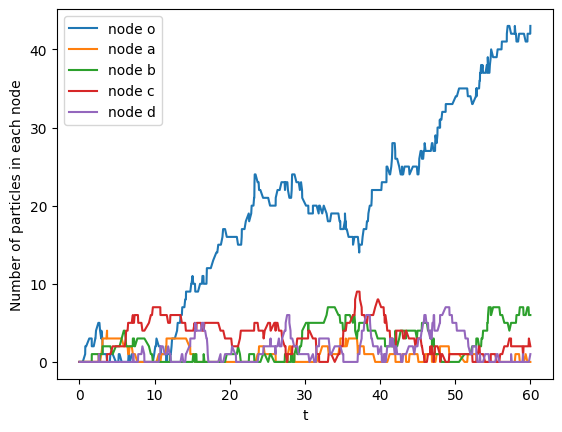

In [32]:
t,q = fixed_rate(2,states,omega,P)# Notice we use P and not Pbar since we are not using a global clock
time = [x[0] for x in t]
for i in range(len(q)):
    plt.plot(time,q[i],label = 'node '+states[i])
plt.xlabel('t')
plt.ylabel('Number of particles in each node')
plt.legend()
plt.show()